In [1]:
"""Political Vector Projector

Given word vectors trained by word2vec (Mikolov et al. 2013) 
or fastText (Bojanowski et al. 2016), project the vectors of 
U.S. senators onto a 'conservative' to 'liberal' axis. 
The scalar components of such projections may be interpreted 
as a valid metric of political ideology.

Learn more about this project at
https://empirical.coffee/blog/2017/political-vector-projector
Author: Albert Webson. MIT License.
"""

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import csv
import re
import os

%matplotlib inline
plt.style.use('seaborn')

# Directory of pre-trained fastText or word2vec models
MODEL_DIR = '../fastText/models/'

## File IO

In [2]:
def parse_vector(line):
    """Return: vector as a list, label"""
    line = line.strip().split()
    return line[1:], line[0]

def validate_shape(shape, vocab_size, embed_dim):
    """Verify the shape of tensor as specified by the first line in .vec"""
    try:
        assert shape == (int(vocab_size), int(embed_dim))
    except AssertionError:
        print('Warning: Something went wrong with file IO!')
        print('The .vec file header line specifies that vocab_size = {}, '
            'embed_dim = {}'.format(vocab_size, embed_dim))
        print('But actually reading the file yielded a tensor of shape {}'
            .format(shape))

def read_vec_file(vec_file):
    """Load a .vec file trained by fastText."""
    labels = []
    vectors = []
    with open(vec_file) as f:
        vocab_size, embed_dim = f.readline().strip().split() 
        for line in f:
            vector, label = parse_vector(line)
            labels.append(label)
            vectors.append(vector)
    vectors = np.array(vectors, np.float32)
    validate_shape(vectors.shape, vocab_size, embed_dim)
    return vectors, labels

def read_vec_file_with_axes(vec_file):
    """Load a .vec file generated by fastText's print-word-vectors command.
    
    The first 4 vectors must be those that define the axes, in the order of 
    [positive_x_axis, negative_x_axis, positive_y_axis, negative_y_axis]
    
    This is taken care of by the gen_queries.py scirpt included with 
    this project, which add ['conservative', 'liberal', 'good', 'bad']
    to the beginning of each queries to fastText's print-word-vectors.
    """
    labels = []
    vectors = []
    axis_labels = []
    axis_vectors = []
    with open(vec_file) as f:
        for i in range(4): # use the first 4 vectors to define axes
            vector, label = parse_vector(f.readline())
            axis_labels.append(label)
            axis_vectors.append(vector)
        for line in f:
            vector, label = parse_vector(line)
            labels.append(label)
            vectors.append(vector)
    vectors = np.array(vectors, np.float32)
    axis_vectors = np.array(axis_vectors, np.float32)
    return vectors, axis_vectors, labels

def read_vec_file_as_dict(vec_file):
    """Read the vector file trained by word2vec, return dict {word: vector}"""
    vec_dict = {}
    with open(vec_file) as f:
        vocab_size, embed_dim = f.readline().strip().split() 
        for line in f:
            vector, label = parse_vector(line)
            vec_dict[label] = np.array(vector, np.float32)
    validate_shape((len(vec_dict), len(vec_dict['coffee'])),
                   vocab_size, embed_dim)
    return vec_dict

def read_dwnominate_csv(csv_file):
    """Read a csv file of DW-NOMINATE data, avaliable at voteview.com"""
    names = []
    ideology_scores = []
    missing = []
    with open(csv_file) as f:
        reader = csv.DictReader(f)
        for row in reader:
            if (row['dim1']):
                ideology_scores.append(row['dim1'])
                names.append(row['bioname'])
            else:
                missing.append(row['bioname'])
                ideology_scores.append('0')
                names.append(row['bioname'] + '(missing score)')
    if missing:
        print("These members' ideology scores are missing from the csv: {}"
            .format(missing))
    ideology_scores = np.array(ideology_scores, np.float32)

    # Re-format names to only contain last name,
    # e.g. 'MOYNIHAN, Daniel Patrick' -> 'moynihan'
    names = [re.sub(',.*', '', i).lower() for i in names]
    return ideology_scores, names

## Vector Projector

In [3]:
def scalar_projection(vectors, axis_vectors):
    """Compute the scarlar components of vector projections.
    
    Assuming the order of axis_vectors is: 
    [positive_x_axis, negative_x_axis, positive_y_axis, negative_y_axis]"""
    x_axis = axis_vectors[0] - axis_vectors[1]
    x_axis = x_axis / np.linalg.norm(x_axis)
    y_axis = axis_vectors[2] - axis_vectors[3]
    y_axis = y_axis / np.linalg.norm(y_axis)
    x_proj = np.dot(vectors, x_axis)
    y_proj = np.dot(vectors, y_axis)
    return x_proj, y_proj
        
def scatter_plot(x_proj, y_proj, labels, title=None, x_label=None,
                 y_label=None, font_size=7, save_dir=None):
    """scatter plot with labels
    
    If save_dir is passed, graph will be higher resolution 
    and saved to to disk."""
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.axhline(linewidth=0.5, color='#1f77b4')
    ax.axvline(linewidth=0.5, color='#1f77b4')
    if save_dir:
        ax.scatter(x_proj, y_proj, s=10)
        for i, label in enumerate(labels):
            ax.annotate(label, (x_proj[i], y_proj[i]), fontsize=font_size)
        ax.tick_params(axis='both', which='major', labelsize=6)
        plt.savefig(save_dir, dpi=500)
    else:    
        ax.scatter(x_proj, y_proj)
        for i, label in enumerate(labels):
            ax.annotate(label, (x_proj[i], y_proj[i]))
            
def evaluate_ideology_projection(vec_file, cgrs_sess, title, save_dir=None):
    """Compare vector projected ideology against DW-NOMINATE."""
    ideology, names = read_dwnominate_csv(
        './dw-nominate/S{}_members.csv'.format(cgrs_sess))
    vectors, axis_vectors, _ = read_vec_file_with_axes(vec_file)
    x_proj, _ = scalar_projection(vectors, axis_vectors)
    try:
        scatter_plot(x_proj, ideology, labels=names, title=title,
            x_label='vector projected ideology (liberal - conservative)',
            y_label='DW-NOMINATE',
            save_dir=save_dir)
    except ValueError:
        print('Failed to graph S{} \n'
              'mismatch in length of x_proj and ideology'.format(cgrs_sess))
    pearson, _ = stats.pearsonr(x_proj, ideology)
    spearman, _ = stats.mstats.spearmanr(x_proj, ideology)
    return pearson, spearman

## Compute statistics over multiple years

In [4]:
def compare_among_years(vec_file, start, end):
    """Invoke evaluate_ideology_projection over multipe sessions of Congress 
    
    vec_file parameter must follow this format: './corpus_S{}.vec'
    where {} is to be replaced with cgrs_sess in range(start, end)
    
    You should first run gen_queries.py to generate a clean 
    namelist for each Congress (along with the axes);
    then run gen_vectors.sh, which uses fastText's print-word-vectors
    to query fastText binary models to generate vectors
    """
    sum_pearson = 0
    sum_spearman = 0
    for cgrs_sess in range(start, end):
        pearson, spearman = evaluate_ideology_projection(
            vec_file.format(cgrs_sess), cgrs_sess, 
            title='{}th U.S. Senate'.format(cgrs_sess))
        print("\n\nPearson's r = {}".format(pearson))
        print("Spearman's rho = {}".format(spearman))
        sum_pearson += pearson
        sum_spearman += spearman
        plt.show()
    print("\n\nAverage Pearson's r = {}".format(sum_pearson / (end - start)))
    print("Average Spearman's rho = {}".format(sum_spearman / (end - start)))

def dict_compare_among_years(vec_dict, start, end):
    """Same functionality as compare_among_years, but for word2vec models.
    
    Reads a vec_dict generated by read_vec_file_as_dict.
    cgrs_sess in range(start, end)
    """
    sum_pearson = 0
    sum_spearman = 0
    axis_vectors = []
    axis = ('conservative', 'liberal', 'good', 'bad')
    for a in axis:
        axis_vectors.append(vec_dict[a])
    axis_vectors = np.array(axis_vectors, np.float32)
    for cgrs_sess in range(start, end):
        ideology, senators = read_dwnominate_csv(
            './dw-nominate/S{}_members.csv'.format(cgrs_sess))
        in_vocab_labels = []
        in_vocab_vec = []
        in_vocab_score = []
        for i, senator in enumerate(senators):
            if (vec_dict.get(senator) is not None):
                in_vocab_labels.append(senator)
                in_vocab_vec.append(vec_dict[senator])
                in_vocab_score.append(ideology[i])
        missing = [w for w in senators if w not in in_vocab_labels]
        if missing:
            print('{}th is missing: {}'.format(cgrs_sess, missing))
        x_proj, _ = scalar_projection(in_vocab_vec, axis_vectors)
        scatter_plot(x_proj, in_vocab_score, labels=in_vocab_labels,
            title='{}th U.S. Senate'.format(cgrs_sess),
            x_label='vector projected ideology (liberal - conservative)',
            y_label='DW-NOMINATE')
        pearson, _ = stats.pearsonr(x_proj, in_vocab_score)
        spearman, _ = stats.mstats.spearmanr(x_proj, in_vocab_score)
        print("\n\nPearson's r = {}".format(pearson))
        print("Spearman's rho = {}".format(spearman))
        sum_pearson += pearson
        sum_spearman += spearman
        plt.show()
    print("\n\nAverage Pearson's r = {}".format(sum_pearson / (end - start)))
    print("Average Spearman's rho = {}".format(sum_spearman / (end - start)))

# Results



Pearson's r = 0.722510814666748
Spearman's rho = 0.7702277083963022


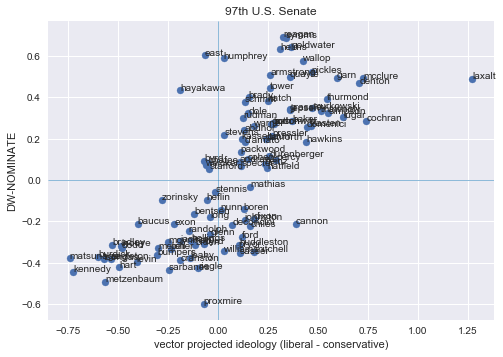



Pearson's r = 0.7646467685699463
Spearman's rho = 0.814777536861473




Pearson's r = 0.7757857441902161
Spearman's rho = 0.8175968334877668


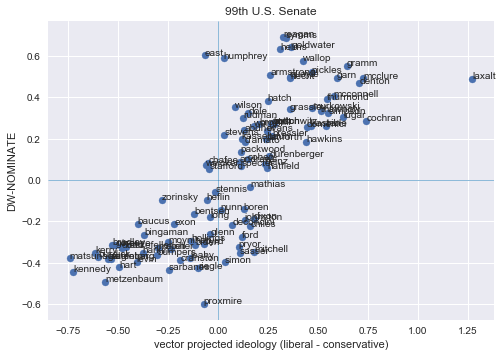



Pearson's r = 0.737393856048584
Spearman's rho = 0.7834910475007509


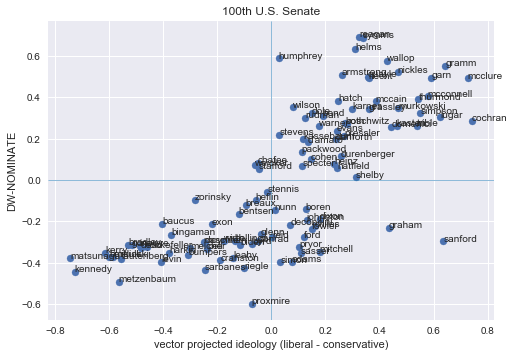



Pearson's r = 0.7367940545082092
Spearman's rho = 0.7744353470405559


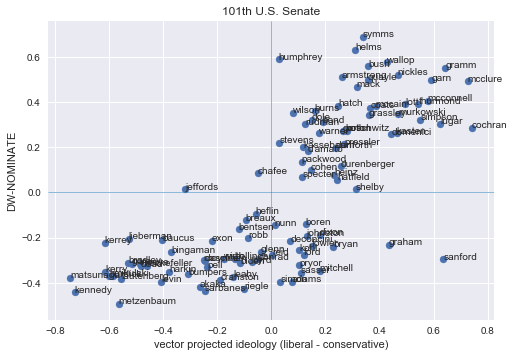



Pearson's r = 0.7085356712341309
Spearman's rho = 0.7411642925505213




Pearson's r = 0.7511775493621826
Spearman's rho = 0.7728208761092454




Pearson's r = 0.7658203840255737
Spearman's rho = 0.7686895197967026


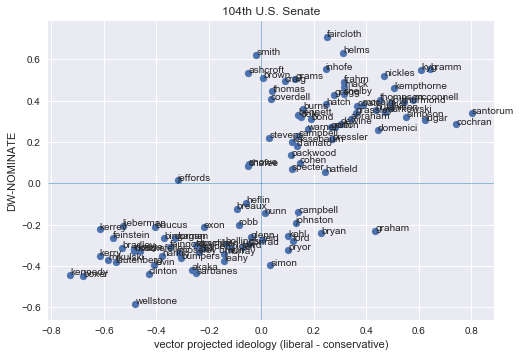



Pearson's r = 0.7578223943710327
Spearman's rho = 0.7374518049257855


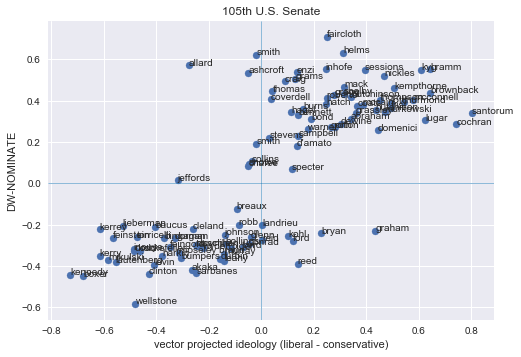



Pearson's r = 0.7666221261024475
Spearman's rho = 0.7514744483860694


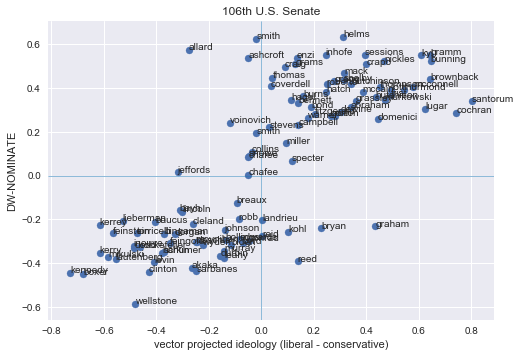

These members' ideology scores are missing from the csv: ['BARKLEY, Dean']


Pearson's r = 0.7966147065162659
Spearman's rho = 0.7789447094095034


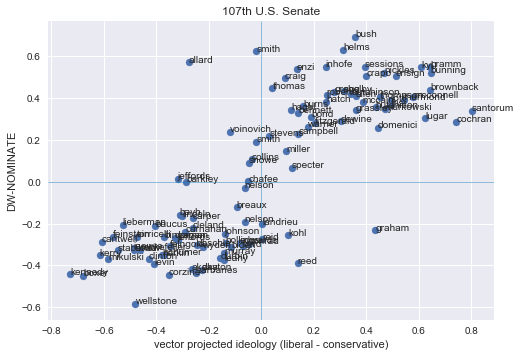



Pearson's r = 0.7895196676254272
Spearman's rho = 0.7805536465188878


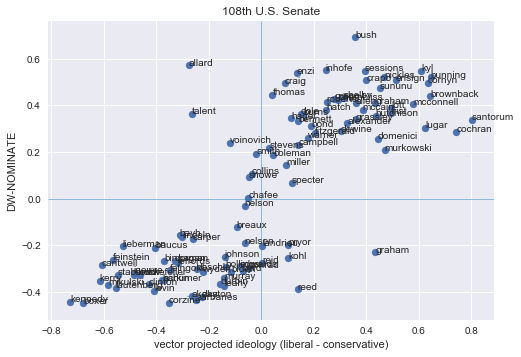



Pearson's r = 0.8171525597572327
Spearman's rho = 0.7930787826461453


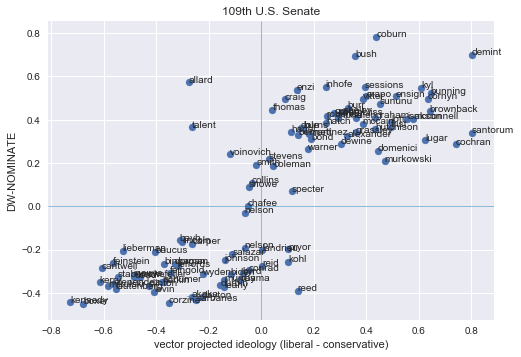



Pearson's r = 0.7891560196876526
Spearman's rho = 0.7668504464646492


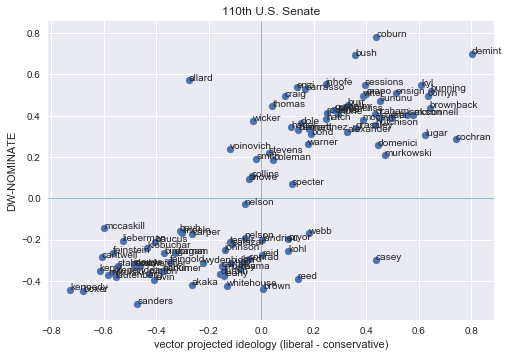



Pearson's r = 0.7518661022186279
Spearman's rho = 0.7215084717529929


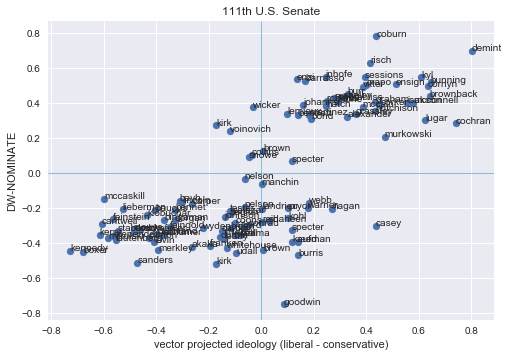



Pearson's r = 0.7333480715751648
Spearman's rho = 0.7122471842347057


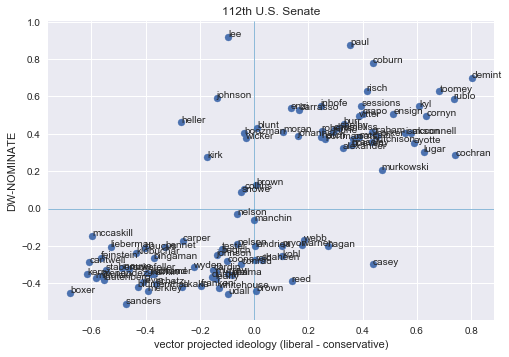



Pearson's r = 0.7240954637527466
Spearman's rho = 0.7185254041513824


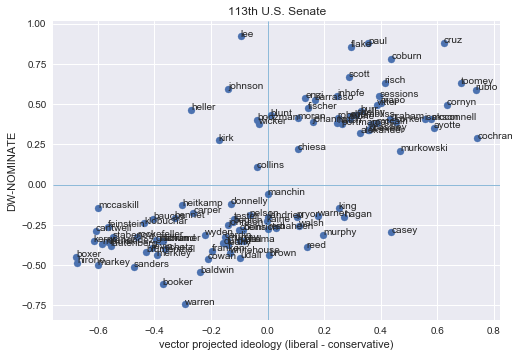



Pearson's r = 0.7178351283073425
Spearman's rho = 0.6795264928864299


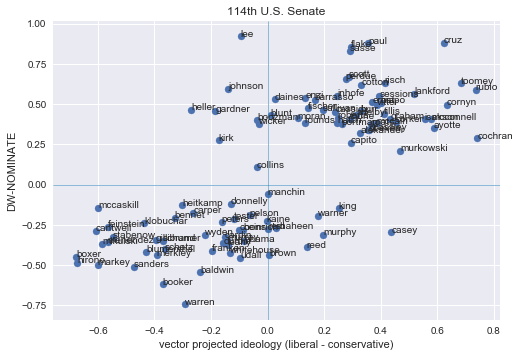



Average Pearson's r = 0.7559276156955295
Average Spearman's rho = 0.7601869196177704


In [5]:
# Examples of fastText models
compare_among_years('./queried_vectors/nyt_97-114/S{}.vec',
                         start=97, end=115)



Pearson's r = 0.7261107563972473
Spearman's rho = 0.7057019931152531


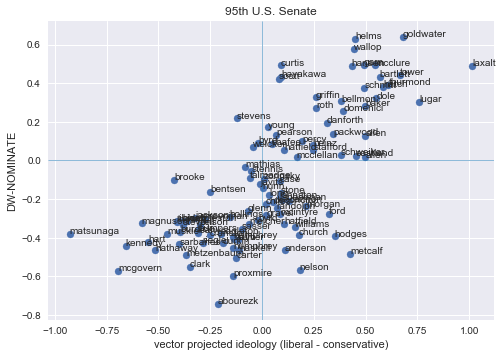



Pearson's r = 0.7600694894790649
Spearman's rho = 0.7726804940329455


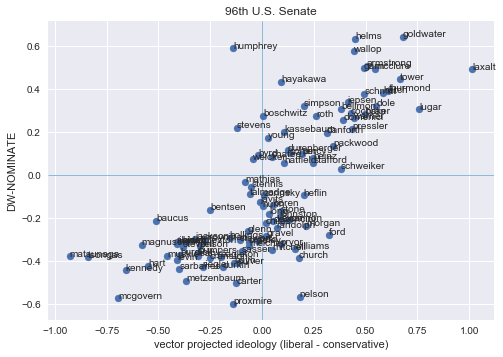



Pearson's r = 0.7895463109016418
Spearman's rho = 0.8098830075504513


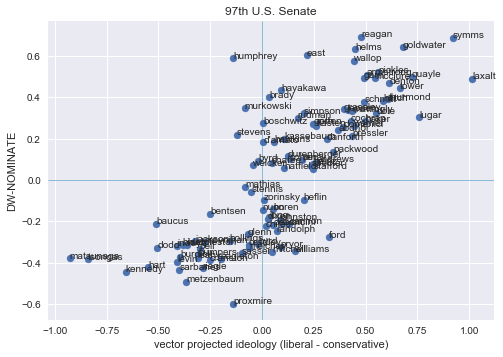



Pearson's r = 0.8181456327438354
Spearman's rho = 0.8451310295215771


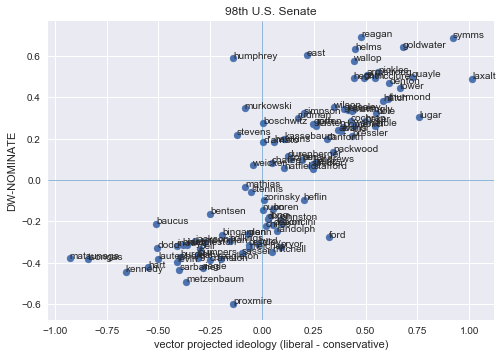



Pearson's r = 0.8257299661636353
Spearman's rho = 0.8510432570110609


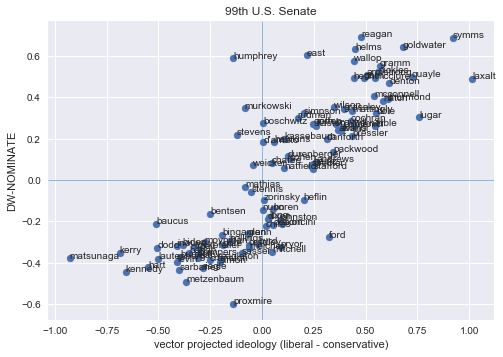



Pearson's r = 0.7889075875282288
Spearman's rho = 0.8178535987107831


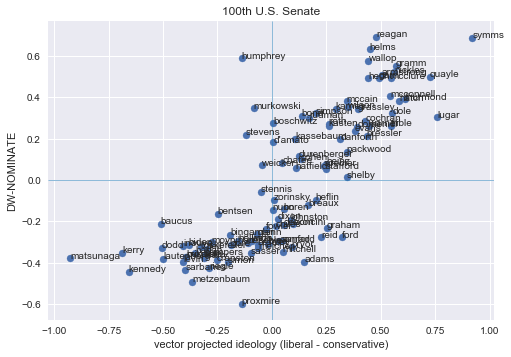



Pearson's r = 0.7826847434043884
Spearman's rho = 0.8057967194511483


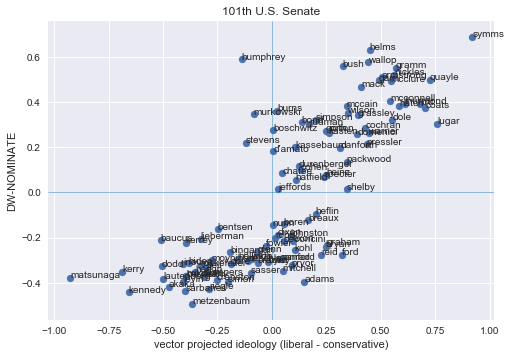



Pearson's r = 0.7837004661560059
Spearman's rho = 0.8053865416206926


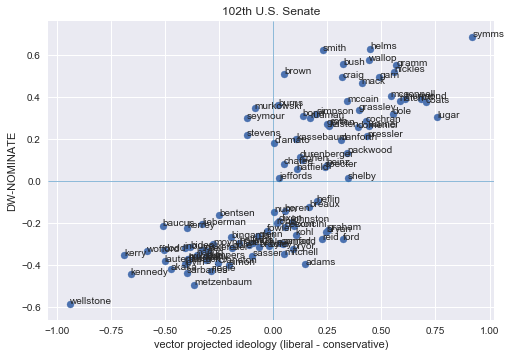



Pearson's r = 0.7878368496894836
Spearman's rho = 0.8148739998914757


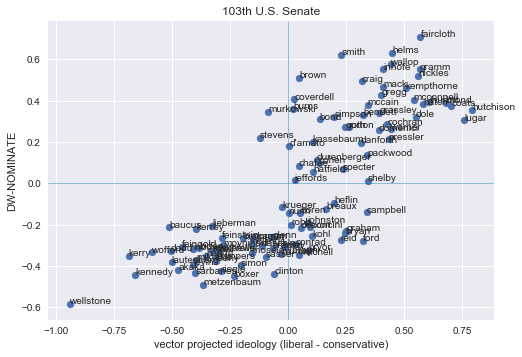



Pearson's r = 0.7836102843284607
Spearman's rho = 0.7944232841602862




Pearson's r = 0.786763072013855
Spearman's rho = 0.7762408414906434


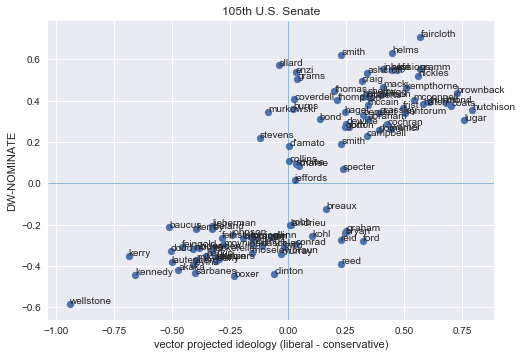



Pearson's r = 0.7884320020675659
Spearman's rho = 0.7763835652546375


These members' ideology scores are missing from the csv: ['BARKLEY, Dean']


Pearson's r = 0.8037465810775757
Spearman's rho = 0.8085161297438791


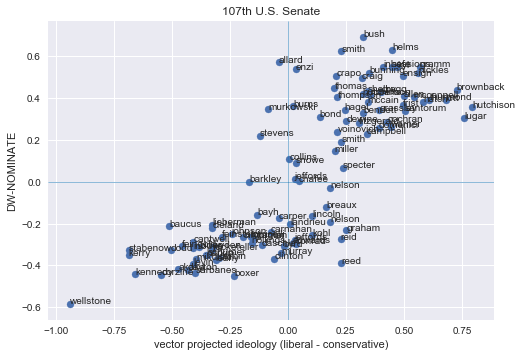



Pearson's r = 0.8080106973648071
Spearman's rho = 0.8121148761196986


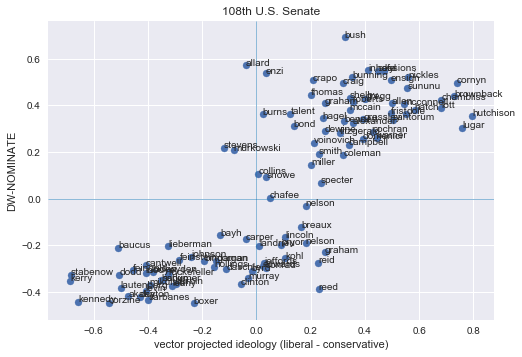



Pearson's r = 0.819696843624115
Spearman's rho = 0.8080351716268449


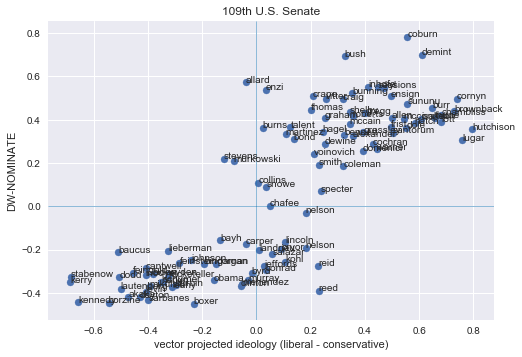



Average Pearson's r = 0.7901994188626608
Average Spearman's rho = 0.8002709672867585


In [6]:
compare_among_years('./queried_vectors/wapo_95-109/S{}.vec',
                         start=95, end=110)



Pearson's r = 0.6758734583854675
Spearman's rho = 0.6793206676954784


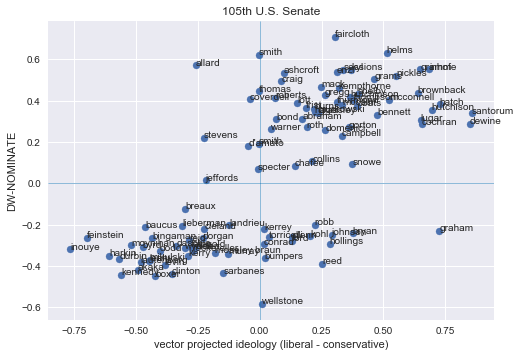



Pearson's r = 0.6983934044837952
Spearman's rho = 0.6934904613897706


These members' ideology scores are missing from the csv: ['BARKLEY, Dean']


Pearson's r = 0.708765983581543
Spearman's rho = 0.7155899319911764




Pearson's r = 0.7318410277366638
Spearman's rho = 0.7321022958916237




Pearson's r = 0.7874338030815125
Spearman's rho = 0.7713934322714824


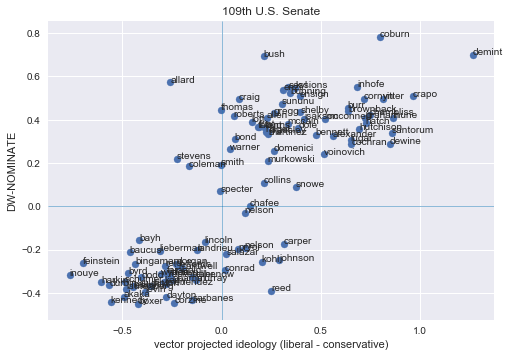



Average Pearson's r = 0.7204615354537964
Average Spearman's rho = 0.7183793578479063


In [7]:
compare_among_years('./queried_vectors/wsj_105-109/S{}.vec',
                         start=105, end=110)

97th is missing: ["d'amato"]


Pearson's r = 0.7685012817382812
Spearman's rho = 0.7951344803219345


98th is missing: ["d'amato"]


Pearson's r = 0.7917909622192383
Spearman's rho = 0.8188132103970914


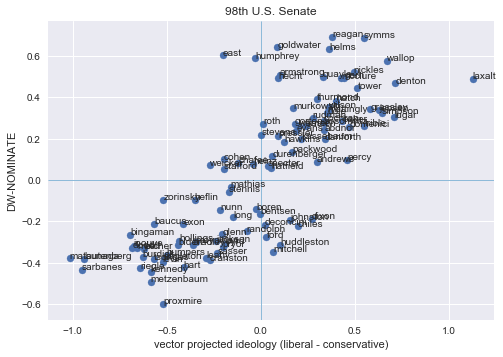

99th is missing: ["d'amato"]


Pearson's r = 0.8123881816864014
Spearman's rho = 0.8364929324133276


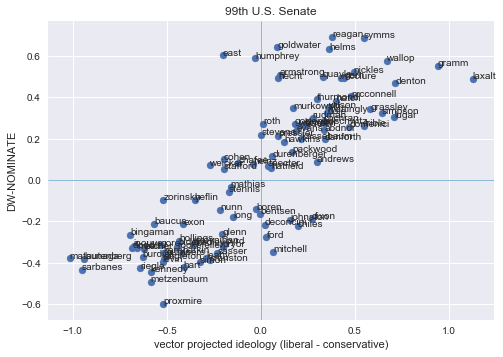

100th is missing: ["d'amato"]


Pearson's r = 0.7887059450149536
Spearman's rho = 0.8162098096683893


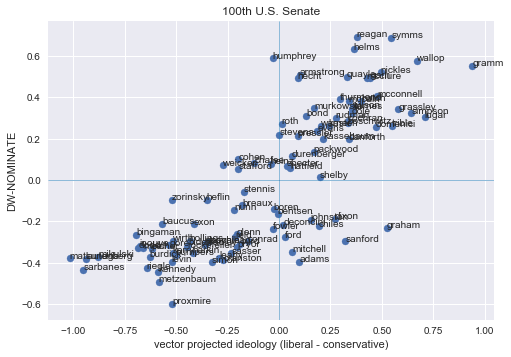

101th is missing: ["d'amato"]


Pearson's r = 0.7857689261436462
Spearman's rho = 0.8037376307733807


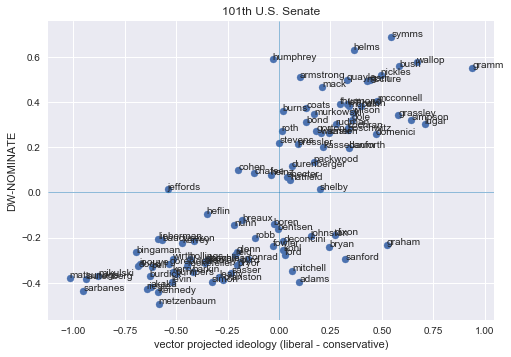

102th is missing: ["d'amato"]


Pearson's r = 0.7683195471763611
Spearman's rho = 0.7847287799321377


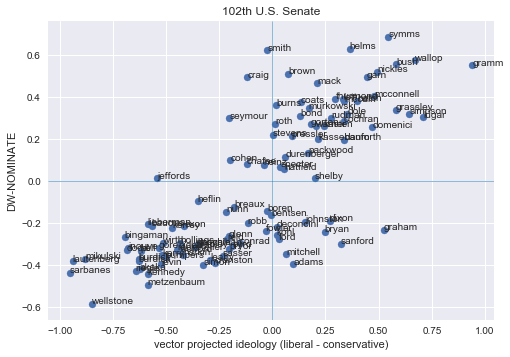

103th is missing: ['moseley braun', "d'amato"]


Pearson's r = 0.7781537175178528
Spearman's rho = 0.7960791850990293


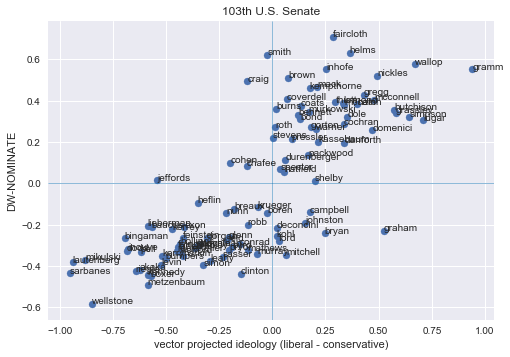

104th is missing: ['moseley braun', "d'amato"]


Pearson's r = 0.794052243232727
Spearman's rho = 0.7909516027924174


105th is missing: ['moseley braun', "d'amato"]


Pearson's r = 0.7774635553359985
Spearman's rho = 0.7660391594352975


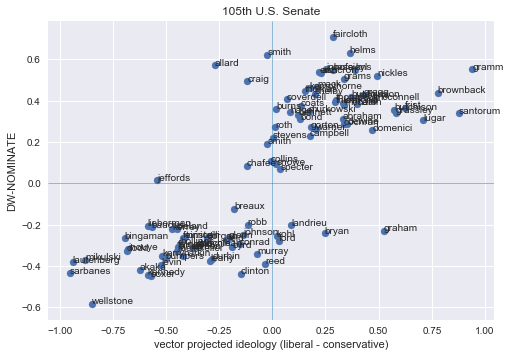



Pearson's r = 0.7746751308441162
Spearman's rho = 0.7619246356437601


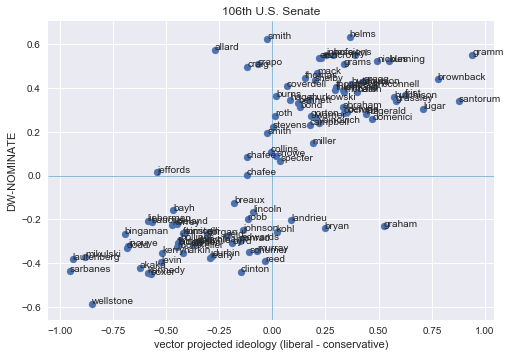

These members' ideology scores are missing from the csv: ['BARKLEY, Dean']


Pearson's r = 0.7974948883056641
Spearman's rho = 0.7815970763587149


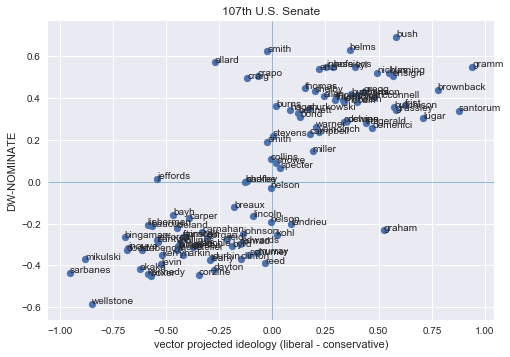



Pearson's r = 0.8008320927619934
Spearman's rho = 0.7872398047734976


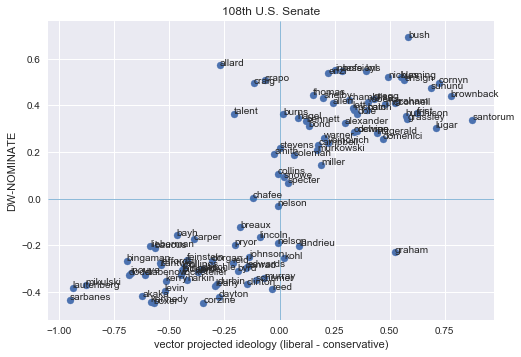



Pearson's r = 0.8238189816474915
Spearman's rho = 0.7941588092228233


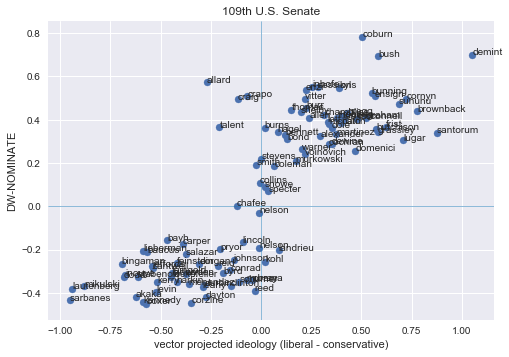



Pearson's r = 0.7869190573692322
Spearman's rho = 0.7468012432705324


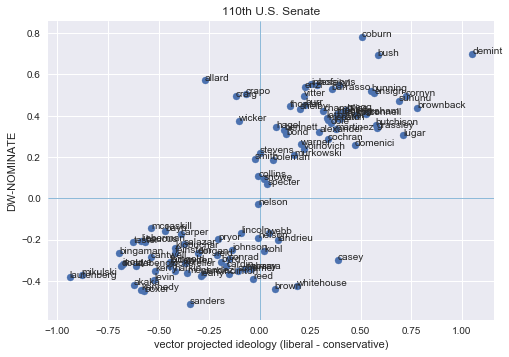



Pearson's r = 0.7542150020599365
Spearman's rho = 0.6994866121957366


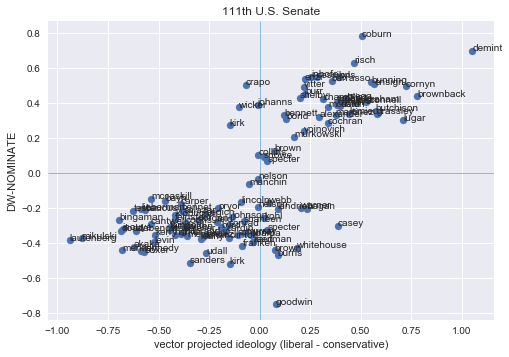



Pearson's r = 0.7406333088874817
Spearman's rho = 0.7160967385980497


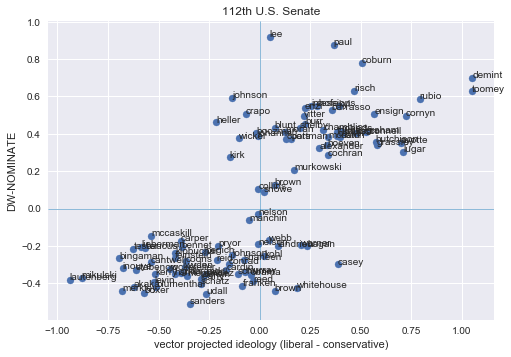



Pearson's r = 0.699846088886261
Spearman's rho = 0.6843862022600551


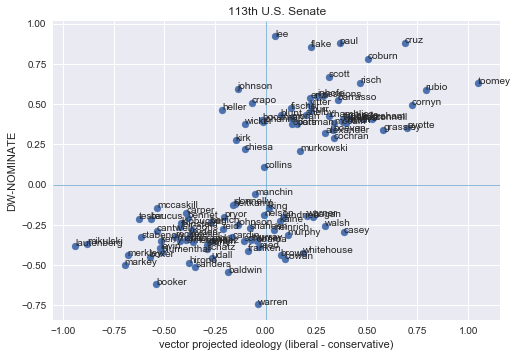



Pearson's r = 0.7146888375282288
Spearman's rho = 0.6872027840388328


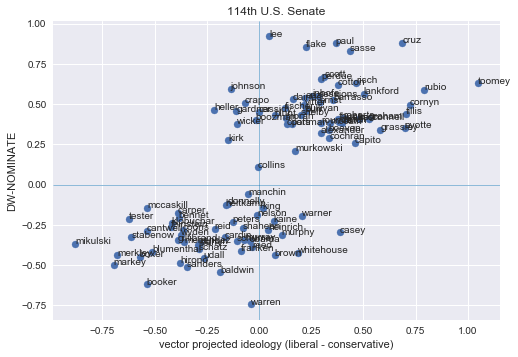



Average Pearson's r = 0.7754593193531036
Average Spearman's rho = 0.7703933720663892


In [8]:
# An example of using a word2vec model. Please provide your own
# pre-trained word2vec models and specify MODEL_DIR.
try:
    vec_dict = read_vec_file_as_dict(
        os.path.join(MODEL_DIR, 'w2v_nyt.txt'))
    dict_compare_among_years(vec_dict, start=97, end=115)
except IOError:
    print('Pre-trained model not found. Please check MODEL_DIR.')

## Projection of Public Policies
Results from this method are quite amusing but still highly experimental. For a detailed account, please refer to https://empirical.coffee/blog/2017/political-vector-projector

In [9]:
from gensim.models.wrappers import FastText
    
def query_fasttext_wrapper(pretrained_model, queries, axes):
    """load fastText binary file, return vectors of given queries
    It's not very fast, but it's faster if you want to
    query vectors on-the-fly, and you don't want to
    manually query C++ fastText via the command line"""
    vectors = [pretrained_model[i] for i in queries]
    vectors = np.array(vectors, np.float32)
    axis_vectors = [pretrained_model[i] for i in axes]
    axis_vectors = np.array(axis_vectors, np.float32)
    return vectors, axis_vectors

def project_queries(pretrained_model, query_file, title=None, save_dir=None):
    with open(query_file) as f:
        # parser skips empty line or comment with #
        queries = [w.strip() for w in f if not (w == '\n' or '#' in w)]
    
    # in the order of: 
    # postive x axis, negative x axis, postive y axis, negative y axis
    axes = ('conservative', 'liberal', 'good', 'bad')
    vectors, axis_vectors = query_fasttext_wrapper(pretrained_model, 
        queries=queries, axes=axes)
    x_proj, y_proj = scalar_projection(vectors, axis_vectors)
    scatter_plot(x_proj, y_proj, labels=queries, title=title,
                     x_label='liberal - conservative',
                     y_label='bad - good',
                     font_size=7, save_dir=save_dir)

In [10]:
nyt_model = FastText.load_fasttext_format(
    os.path.join(MODEL_DIR, 'nyt_1981-2016'))

In [11]:
wsj_model = FastText.load_fasttext_format(
    os.path.join(MODEL_DIR, 'wsj_1997-2017'))

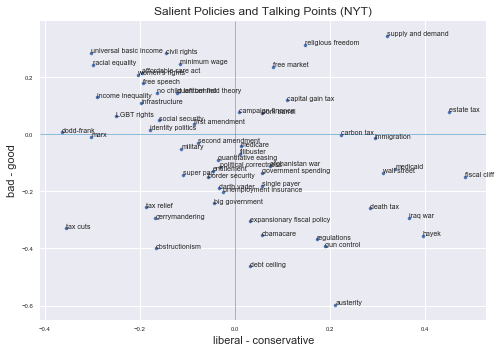

In [12]:
project_queries(nyt_model, query_file='./queries/salient_policies.md',
                title='Salient Policies and Talking Points (NYT)',
                save_dir='./graphs/NYT policies.png')

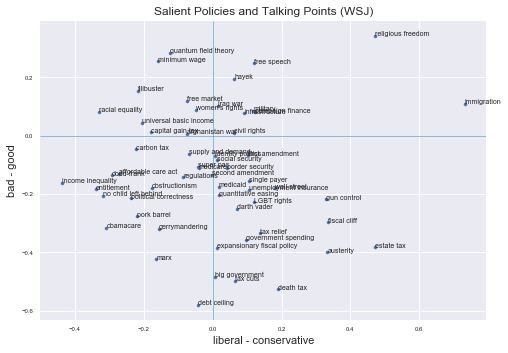

In [13]:
project_queries(wsj_model, query_file='./queries/salient_policies.md',
                title='Salient Policies and Talking Points (WSJ)',
                save_dir='./graphs/WSJ policies.png')